In [1]:
from kmeanspp import kmeans_3chan, reduce_colorspace
import numpy as np
import matplotlib.pyplot as plt

In [2]:
test_img = plt.imread("test_img.jpg")
result = reduce_colorspace(test_img, 16, 10)

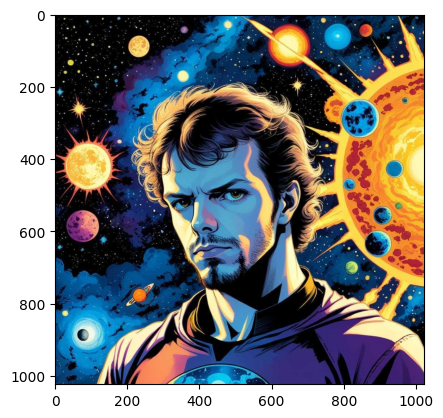

In [3]:
import matplotlib.pyplot as plt
plt.imshow(test_img)

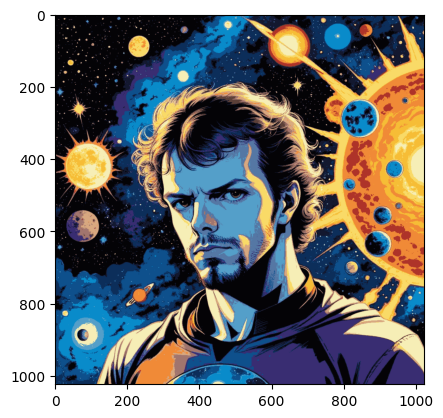

In [4]:
plt.imshow(result)
plt.show()

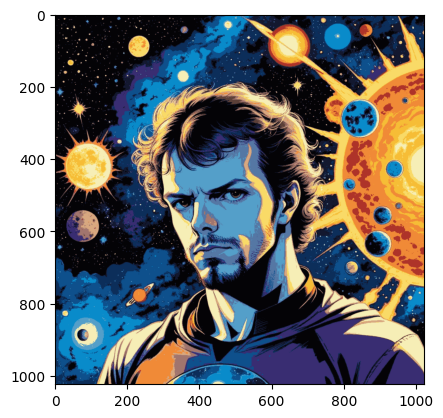

  0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
import time
import cv2
from tqdm.auto import tqdm
## Collect runtime data
# data = {}
n_pixel_key = "n_pixels"
n_colors_key = "n_colors"
time_key = "time"

ITERATIONS = 500

min_d = 256
max_d = 1920

min_colors = 2
max_colors=30
plt.imshow(result)
plt.show()
for i in tqdm(range(ITERATIONS)):
    d = np.random.randint(min_d, max_d)
    n_colors = np.random.randint(min_colors, max_colors)

    new_photo = cv2.resize(test_img, (d, d))

    start_time = time.time()
    reduce_colorspace(new_photo, n_colors, 1)
    end_time = time.time()
    data[i] = {n_pixel_key: new_photo.size, n_colors_key: n_colors, time_key: end_time - start_time}

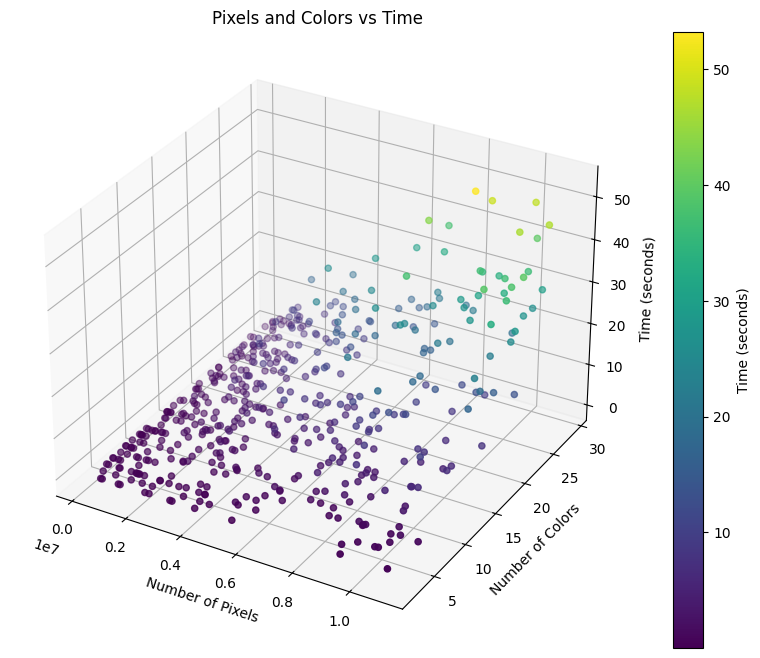

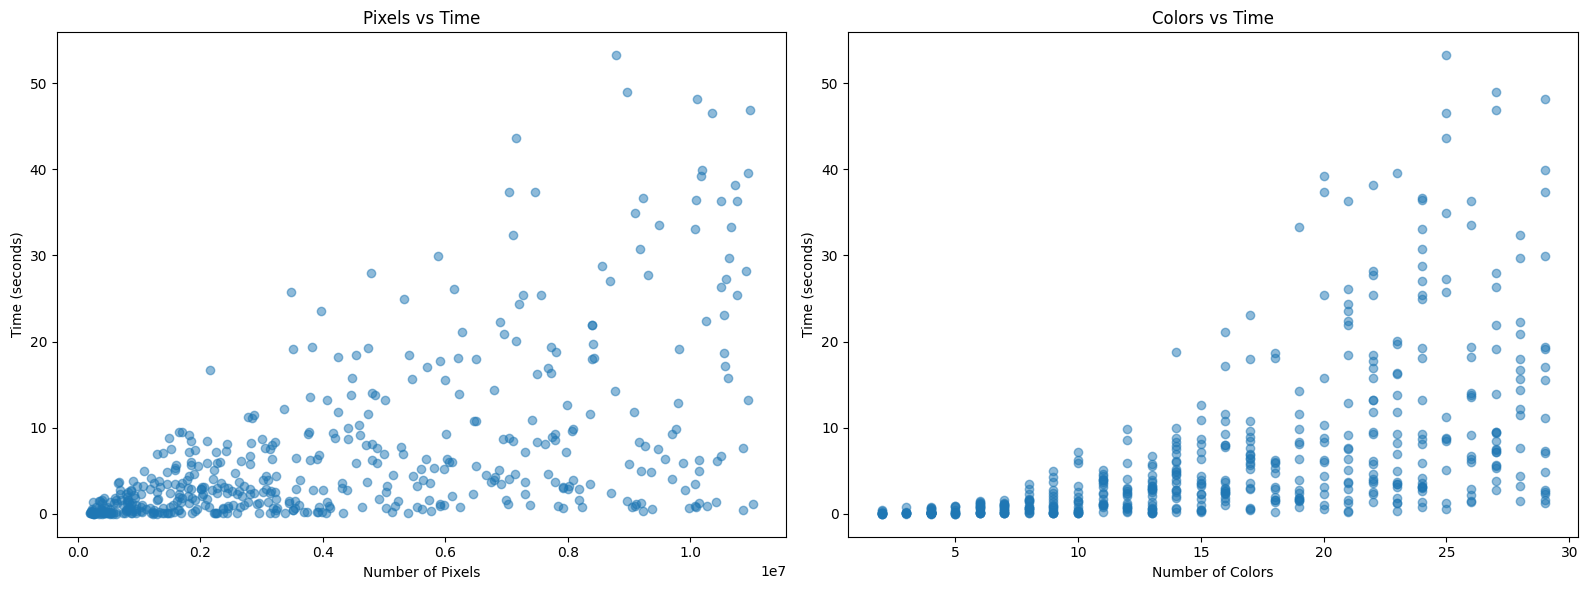

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data from the dictionary
pixels = np.array([d[n_pixel_key] for d in data.values()])
colors = np.array([d[n_colors_key] for d in data.values()])
times = np.array([d[time_key] for d in data.values()])

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter points
scatter = ax.scatter(pixels, colors, times, c=times, cmap='viridis')

# Set labels and title
ax.set_xlabel('Number of Pixels')
ax.set_ylabel('Number of Colors')
ax.set_zlabel('Time (seconds)')
ax.set_title('Pixels and Colors vs Time')

# Add a color bar
cbar = fig.colorbar(scatter)
cbar.set_label('Time (seconds)')

# Show the plot
plt.show()

# Create 2D plots for better visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Pixels vs Time
ax1.scatter(pixels, times, alpha=0.5)
ax1.set_xlabel('Number of Pixels')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Pixels vs Time')

# Colors vs Time
ax2.scatter(colors, times, alpha=0.5)
ax2.set_xlabel('Number of Colors')
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Colors vs Time')

plt.tight_layout()
plt.show()


Mean squared error: 16.5379
R-squared score: 0.8197

Model coefficients:
pixels^1: 0.000007
pixels^2: -4.622949
colors^1: 0.008454
colors^2: -0.811047
log(pixels): -0.000000
log(colors): 0.000000
Intercept: 11.316106


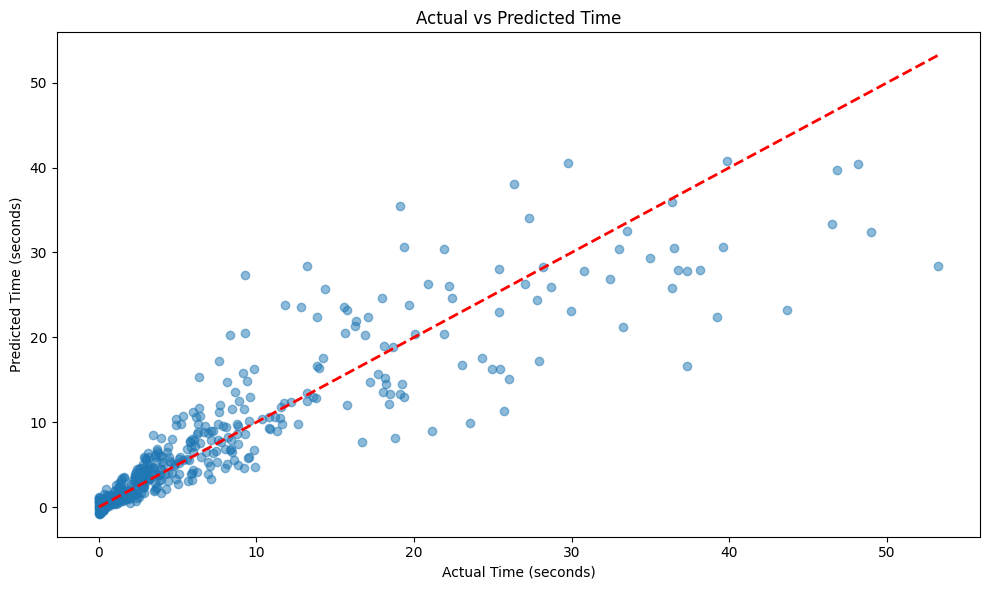

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Prepare the input features
X = np.column_stack((pixels, colors))
y = times

# Add log factors
X_with_log = np.column_stack((X, np.log(pixels + 1), np.log(colors + 1)))

# Create polynomial features (degree 2) and fit the model
degree = 2
model = make_pipeline(
    PolynomialFeatures(degree, include_bias=False),
    LinearRegression()
)
model.fit(X_with_log, y)

# Make predictions
y_pred = model.predict(X_with_log)

# Calculate metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Mean squared error: {mse:.4f}")
print(f"R-squared score: {r2:.4f}")

# Get feature names
feature_names = [f"pixels^{i}" for i in range(1, degree+1)] + \
                [f"colors^{i}" for i in range(1, degree+1)] + \
                ["log(pixels)", "log(colors)"]

# Print coefficients
coefficients = model.named_steps['linearregression'].coef_
intercept = model.named_steps['linearregression'].intercept_

print("\nModel coefficients:")
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef:.6f}")
print(f"Intercept: {intercept:.6f}")

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual Time (seconds)")
plt.ylabel("Predicted Time (seconds)")
plt.title("Actual vs Predicted Time")
plt.tight_layout()
plt.show()


In [25]:
from sklearn.pipeline import Pipeline
def predict_time(pixels: int, colors: int, model: Pipeline) -> float:
    """
    Predict the processing time based on the number of pixels and colors using the trained model.

    Args:
        pixels (int): Number of pixels in the image.
        colors (int): Number of colors in the image.
        model (Pipeline): Trained scikit-learn pipeline containing PolynomialFeatures and LinearRegression.

    Returns:
        float: Predicted processing time in seconds.
    """
    # Create input features
    X_input = np.array([[pixels, colors, np.log(pixels + 1), np.log(colors + 1)]])
    
    # Make prediction
    predicted_time = model.predict(X_input)[0]
    
    return predicted_time

# Example usage:
sample_pixels = 1900 * 1900
sample_colors = 10
predicted_time = predict_time(sample_pixels, sample_colors, model)
print(f"Predicted time for {sample_pixels} pixels and {sample_colors} colors: {predicted_time:.2f} seconds")


Predicted time for 3610000 pixels and 10 colors: 1.50 seconds


In [27]:
def predict_time(pixels: int, colors: int) -> float:
    return (
        0.000000 * pixels +
        0.000000 * pixels**2 +
        0.001644 * colors +
        0.000037 * colors**2 +
        -0.000000 * pixels * colors +
        0.000005 * np.log(pixels + 1) +
        0.003292 * np.log(colors + 1) +
        -0.000344  # Intercept
    )

ValueError: input_features should have length equal to number of features (4), got 2